The intent behind this notebook is to study the effect of various preprocessing and other optimization techniques for the multivariate GRU network which showed the best performance during the Grid Search. That is, multilayered multivariate forecast data GRU with 128 and 128 neurons

Though the optimal model was found to be univariate price multilayered SimpleRNN with 128 and 128 neurons with MSE @ 0.06939392, we want to see if preprocessing of the GRU network can obtain similar or better performance.

The following will be tested:

* Preprocessing FeedForward Layer - leaky relu

* 1D convolutional layer

* Experimenting with dropout and recurrent dropout

* Experimenting with batch size

Based on these results, combinations inbetween experiments may be looked at

# Loading and structuring the data

In [1]:
from sklearn.metrics import mean_absolute_error as MSE
from cmcrameri import cm
from tqdm import tqdm
import seaborn as sns
from common import *
from models import *

2021-12-17 13:36:52.370545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-17 13:36:52.370587: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv("../data/input_data/MAIN_DATASET.csv")

price = df['NO2_price'].values.reshape(-1,1)
fload = df['NO2_load_forecasted'].values.reshape(-1,1)
fgen = df['NO2_generation_forecast'].values.reshape(-1,1)


# price_days = seperate_column_to_days(price)
# fload_days = seperate_column_to_days(fload)
# fgen_days = seperate_column_to_days(fgen)

In [3]:
scaler = MinMaxScaler()
price = scaler.fit_transform(price)
fload = scaler.fit_transform(fload)
fgen = scaler.fit_transform(fgen)

In [4]:
lookbehind = 7
input_width = lookbehind*24
horizon = 24
no_hours = input_width + horizon
#hour_in_days = int(no_hours / 24)

price_dataset = []
fload_dataset = []
fgen_dataset = []

# for i in range(len(price_days) - hour_in_days+1):
#     price_dataset.append(np.concatenate((price_days[i:i+hour_in_days])))
#     fload_dataset.append(np.concatenate((fload_days[i:i+hour_in_days])))
#     fgen_dataset.append(np.concatenate((fgen_days[i:i+hour_in_days])))

for i in range(0, len(price)-input_width, horizon):
    price_dataset.append(price[i:i+no_hours])
    fload_dataset.append(fload[i:i+no_hours])
    fgen_dataset.append(fgen[i:i+no_hours])


price_dataset = np.array(price_dataset)
fload_dataset = np.array(fload_dataset)
fgen_dataset = np.array(fgen_dataset)

"""
scaler = MinMaxScaler()
price_dataset = scaler.fit_transform(price_dataset[:,:,0])
price_dataset = price_dataset[..., np.newaxis].astype(np.float32)

fload_dataset = scaler.fit_transform(fload_dataset[:,:,0])
fload_dataset = fload_dataset[..., np.newaxis].astype(np.float32)

fgen_dataset = scaler.fit_transform(fgen_dataset[:,:,0])
fgen_dataset = fgen_dataset[..., np.newaxis].astype(np.float32)
"""

dataset_forecast = np.concatenate((price_dataset, fload_dataset, fgen_dataset), axis=2)

n,m,k = dataset_forecast.shape

In [5]:
train = int(0.7*n)
valid = int(0.9*n)
X_train = dataset_forecast[:train, :input_width]
X_valid = dataset_forecast[train:valid, :input_width]
X_test = dataset_forecast[valid:, :input_width]

Y = np.empty((n, input_width, horizon))
for step_ahead in range(1, horizon + 1):
    Y[:,:, step_ahead - 1] = dataset_forecast[:,step_ahead:step_ahead + input_width, 0]

Y_train = Y[:train]
Y_valid = Y[train:valid]
Y_test = Y[valid:]

# Shared Parameters

In [6]:
epochs = 10
neurons_first = 128
neurons_second = 128

# Studying the effect of one and two FeedForward PreProc layer

In [7]:
no_neurons = np.array([0,16,32,64])

best_mse_ff = np.inf
mse_list_ff = np.zeros((len(no_neurons[1:]),len(no_neurons)))

In [8]:
for n, ff_neurons in enumerate(no_neurons[1:]):
    for m, fs_neurons in enumerate(no_neurons):
        print(f"Iteration {n}{m}")

        if m == 0:
            gru = keras.models.Sequential([
                keras.layers.Dense(ff_neurons, activation='leaky_relu', input_shape=[None, k]),
                keras.layers.GRU(neurons_first, return_sequences=True),
                keras.layers.GRU(neurons_second, return_sequences=True),
                keras.layers.Dense(horizon)
            ])
        
        else:
            gru = keras.models.Sequential([
                keras.layers.Dense(ff_neurons, activation='leaky_relu', input_shape=[None, k]),
                keras.layers.Dense(fs_neurons, activation='leaky_relu'),
                keras.layers.GRU(neurons_first, return_sequences=True),
                keras.layers.GRU(neurons_second, return_sequences=True),
                keras.layers.Dense(horizon)
            ])

        gru.compile(loss="mse", optimizer="adam")

        gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)


        Y_pred_gru = gru.predict(X_test)


        mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

        if mse_gru < best_mse_ff:
            print(f"Found new best GRU mse {mse_gru} with FeedForward {ff_neurons} and {fs_neurons} neurons")
            best_mse_ff = mse_gru
            #fname = f"../data/models/multivariate_forecast_ff_gru.h5"
            #keras.models.save_model(gru, fname)

        mse_list_ff[n,m] = mse_gru

Iteration 00


2021-12-17 13:36:54.071339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-17 13:36:54.071442: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-17 13:36:54.071490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-17 13:36:54.071551: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-17 13:36:54.071597: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Found new best GRU mse 0.03837176714215985 with FeedForward 16 and 0 neurons
Iteration 01
Iteration 02
Found new best GRU mse 0.029797029025539618 with FeedForward 16 and 32 neurons
Iteration 03
Found new best GRU mse 0.028944049750354892 with FeedForward 16 and 64 neurons
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 20
Iteration 21
Iteration 22
Iteration 23


In [9]:
print(mse_list_ff)

[[0.03837177 0.04137681 0.02979703 0.02894405]
 [0.03164721 0.03338991 0.03313941 0.03115915]
 [0.02962676 0.02975538 0.03043537 0.030249  ]]


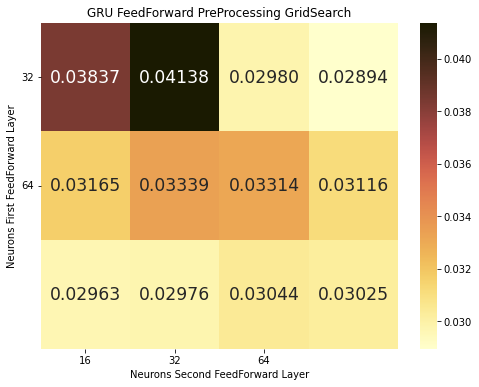

In [24]:
plt.figure(figsize=(8,6))
gridsearch = sns.heatmap(mse_list_ff,annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= no_neurons, yticklabels= no_neurons[1:], cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

plt.title("GRU FeedForward PreProcessing GridSearch")
plt.xlabel("Neurons Second FeedForward Layer")
plt.ylabel("Neurons First FeedForward Layer")
plt.savefig(f"../figures/Large_forecast_ff_gridsearch_gru.pdf")

# 1d convolution

In [11]:
no_neurons = np.array([16,32,64])
kernel_size = np.array([2,3,4,5])

best_mse_conv = np.inf
mse_list_conv = np.zeros((len(no_neurons),len(kernel_size)))

In [12]:
for n, conv_neurons in enumerate(no_neurons):
    for m, kernel in enumerate(kernel_size):
        print(f"Iteration {n}{m}")

        gru = keras.models.Sequential([
            keras.layers.Conv1D(filters=conv_neurons, kernel_size=int(kernel), strides=3, padding="valid", input_shape=[None, k]),
            keras.layers.GRU(neurons_first, return_sequences=True),
            keras.layers.GRU(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        gru.compile(loss="mse", optimizer="adam")

        gru.fit(X_train, Y_train[:,kernel-1::3], epochs=epochs, validation_data=(X_valid, Y_valid[:,kernel-1::3]), verbose=False)

        Y_pred_gru = gru.predict(X_test)

        mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

        if mse_gru < best_mse_conv:
            print(f"Found new best GRU mse {mse_gru} with Convolution {conv_neurons} neurons and {kernel} kernel size")
            best_mse_conv = mse_gru
            #fname = f"../data/models/multivariate_forecast_conv_gru.h5"
            #keras.models.save_model(gru, fname)

        mse_list_conv[n,m] = mse_gru

Iteration 00
Found new best GRU mse 0.029334121161034964 with Convolution 16 neurons and 2 kernel size
Iteration 01
Found new best GRU mse 0.028686032643298234 with Convolution 16 neurons and 3 kernel size
Iteration 02
Iteration 03
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 20
Iteration 21
Found new best GRU mse 0.027825740981798158 with Convolution 64 neurons and 3 kernel size
Iteration 22
Iteration 23


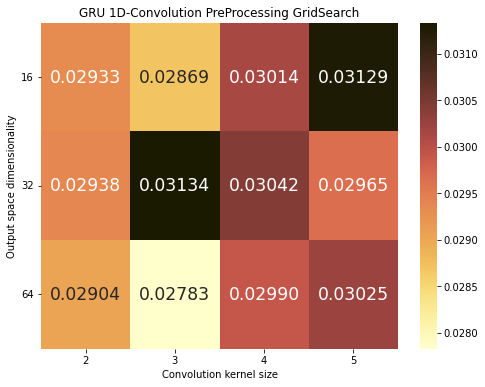

In [25]:
plt.figure(figsize=(8,6))
gridsearch = sns.heatmap(mse_list_conv,annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= kernel_size, yticklabels=no_neurons, cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

plt.title("GRU 1D-Convolution PreProcessing GridSearch")
plt.xlabel("Convolution kernel size")
plt.ylabel("Output space dimensionality")
plt.savefig(f"../figures/Large_forecast_conv_gridsearch_gru.pdf")

# Setting down the stride to two

In [14]:
"""
best_mse_conv_2 = np.inf
mse_list_conv_2 = np.zeros((len(no_neurons),len(kernel_size)))
"""

'\nbest_mse_conv_2 = np.inf\nmse_list_conv_2 = np.zeros((len(no_neurons),len(kernel_size)))\n'

In [15]:
"""for n, conv_neurons in enumerate(no_neurons):
    for m, kernel in enumerate(kernel_size):
        print(f"Iteration {n}{m}")

        gru = keras.models.Sequential([
            keras.layers.Conv1D(filters=conv_neurons, kernel_size=int(kernel), strides=2, padding="valid", input_shape=[None, k]),
            keras.layers.GRU(neurons_first, return_sequences=True),
            keras.layers.GRU(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        gru.compile(loss="mse", optimizer="adam")

        gru.fit(X_train, Y_train[:,kernel-1::2], epochs=epochs, validation_data=(X_valid, Y_valid[:,kernel-1::2]), verbose=False)

        Y_pred_gru = gru.predict(X_test)

        mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

        if mse_gru < best_mse_conv:
            print(f"Found new best GRU mse {mse_gru} with Convolution {conv_neurons} neurons and {kernel} kernel size")
            best_mse_conv = mse_gru
            fname = f"../data/models/multivariate_forecast_conv_gru_2.h5"
            keras.models.save_model(gru, fname)

        mse_list_conv[n,m] = mse_gru
"""

'for n, conv_neurons in enumerate(no_neurons):\n    for m, kernel in enumerate(kernel_size):\n        print(f"Iteration {n}{m}")\n\n        gru = keras.models.Sequential([\n            keras.layers.Conv1D(filters=conv_neurons, kernel_size=int(kernel), strides=2, padding="valid", input_shape=[None, k]),\n            keras.layers.GRU(neurons_first, return_sequences=True),\n            keras.layers.GRU(neurons_second, return_sequences=True),\n            keras.layers.Dense(horizon)\n        ])\n\n        gru.compile(loss="mse", optimizer="adam")\n\n        gru.fit(X_train, Y_train[:,kernel-1::2], epochs=epochs, validation_data=(X_valid, Y_valid[:,kernel-1::2]), verbose=False)\n\n        Y_pred_gru = gru.predict(X_test)\n\n        mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])\n\n        if mse_gru < best_mse_conv:\n            print(f"Found new best GRU mse {mse_gru} with Convolution {conv_neurons} neurons and {kernel} kernel size")\n            best_mse_conv = mse_gru\n            fname =

In [16]:
"""
plt.figure(figsize=(8,6))
gridsearch = sns.heatmap(mse_list_conv,annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= kernel_size, yticklabels=no_neurons, cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

plt.title("GRU 1D-Convolution PreProcessing GridSearch")
plt.xlabel("Convolution kernel size")
plt.ylabel("Output space dimensionality")
plt.savefig(f"../figures/Large_forecast_conv_gridsearch_gru_2.pdf")
"""

'\nplt.figure(figsize=(8,6))\ngridsearch = sns.heatmap(mse_list_conv,annot=True, annot_kws={\'fontsize\':\'xx-large\'}, fmt=".5f", xticklabels= kernel_size, yticklabels=no_neurons, cmap=cm.lajolla)\ngridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)\n\nplt.title("GRU 1D-Convolution PreProcessing GridSearch")\nplt.xlabel("Convolution kernel size")\nplt.ylabel("Output space dimensionality")\nplt.savefig(f"../figures/Large_forecast_conv_gridsearch_gru_2.pdf")\n'

# Dropout

In [17]:
dropouts = np.array([0.0, 0.1, 0.2, 0.3])

best_mse_dropout = np.inf
mse_list_dropout = np.zeros((len(dropouts),len(dropouts)))

In [18]:
for n, dropout in enumerate(dropouts):
    for m, r_dropout in enumerate(dropouts):
        print(f"Iteration {n}{m}")

        gru = keras.models.Sequential([
            keras.layers.GRU(neurons_first, dropout=dropout, recurrent_dropout=r_dropout, return_sequences=True, input_shape=[None,k]),
            keras.layers.GRU(neurons_second, dropout=dropout, recurrent_dropout=r_dropout, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        gru.compile(loss="mse", optimizer="adam")

        gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

        Y_pred_gru = gru.predict(X_test)

        mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

        if mse_gru < best_mse_dropout:
            print(f"Found new best GRU mse {mse_gru} with Dropout {dropout} dropout and {r_dropout} recurrent dropout")
            best_mse_dropout = mse_gru
            #fname = f"../data/models/multivariate_forecast_dropout_gru.h5"
            #keras.models.save_model(gru, fname)

        mse_list_dropout[n,m] = mse_gru

Iteration 00
Found new best GRU mse 0.029134389992423442 with Dropout 0.0 dropout and 0.0 recurrent dropout
Iteration 01
Iteration 02
Iteration 03
Found new best GRU mse 0.028005856617520152 with Dropout 0.0 dropout and 0.3 recurrent dropout
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 30
Iteration 31
Iteration 32
Iteration 33


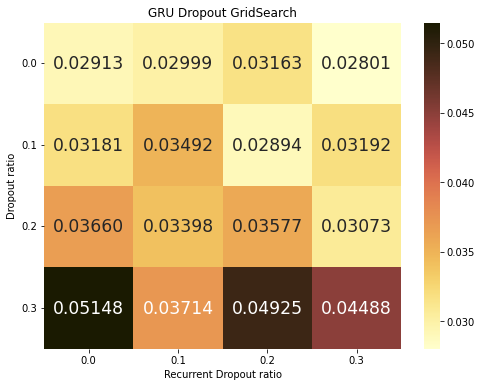

In [26]:
plt.figure(figsize=(8,6))
gridsearch = sns.heatmap(mse_list_dropout,annot=True, annot_kws={'fontsize':'xx-large'}, fmt=".5f", xticklabels= dropouts, yticklabels=dropouts, cmap=cm.lajolla)
gridsearch.set_yticklabels(gridsearch.get_yticklabels(),rotation = 0)

plt.title("GRU Dropout GridSearch")
plt.xlabel("Recurrent Dropout ratio")
plt.ylabel("Dropout ratio")
plt.savefig(f"../figures/Large_forecast_dropout_gridsearch_gru.pdf")

# Regularization

In [20]:
from keras.regularizers import L2

In [21]:
regularizers = np.logspace(-2,-3,2)
regularizers = np.concatenate(([0], regularizers))

best_mse_reg = np.inf
mse_list_reg = np.zeros((len(regularizers), len(regularizers), len(regularizers)))

In [22]:
for n, reg_bias in enumerate(regularizers):
    for m, reg_weight in enumerate(regularizers):
        for l, reg_rec in enumerate(regularizers):   
            print(f"Iteration {n}{m}{l}")

            gru = keras.models.Sequential([
                keras.layers.GRU(neurons_first, bias_regularizer=L2(l2=reg_bias), kernel_regularizer=L2(l2=reg_weight), recurrent_regularizer=L2(l2=reg_rec), return_sequences=True, input_shape=[None,k]),       
                keras.layers.GRU(neurons_second, bias_regularizer=L2(l2=reg_bias), kernel_regularizer=L2(l2=reg_weight), recurrent_regularizer=L2(l2=reg_rec), return_sequences=True),
                keras.layers.Dense(horizon)
            ])

            gru.compile(loss="mse", optimizer="adam")

            gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

            Y_pred_gru = gru.predict(X_test)

            mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

            if mse_gru < best_mse_reg:
                print(f"Found new best GRU mse {mse_gru} with Bias reg {reg_bias} Input reg {reg_weight} and Recurrent reg {reg_rec}")
                best_mse_reg = mse_gru
                #fname = f"../data/models/multivariate_forecast_reg_gru.h5"
                #keras.models.save_model(gru, fname)

            mse_list_reg[n,m,l] = mse_gru

Iteration 000
Found new best GRU mse 0.029224401522509148 with Bias reg 0.0 Input reg 0.0 and Recurrent reg 0.0
Iteration 001
Iteration 002
Found new best GRU mse 0.028686321557515247 with Bias reg 0.0 Input reg 0.0 and Recurrent reg 0.001
Iteration 010
Iteration 011
Iteration 012
Iteration 020
Iteration 021
Iteration 022
Iteration 100
Iteration 101
Iteration 102
Iteration 110
Iteration 111
Iteration 112
Iteration 120
Iteration 121
Iteration 122
Iteration 200
Iteration 201
Iteration 202
Iteration 210
Iteration 211
Iteration 212
Iteration 220
Iteration 221
Iteration 222


In [23]:
print(mse_list_reg)

[[[0.0292244  0.02932258 0.02868632]
  [0.14455938 0.14403089 0.15385121]
  [0.02904753 0.14207197 0.14264146]]

 [[0.03283201 0.02914197 0.03002496]
  [0.14463962 0.14495011 0.14469   ]
  [0.03053417 0.15817502 0.14581037]]

 [[0.03001975 0.02907758 0.03146721]
  [0.14204958 0.14416505 0.14104596]
  [0.03697437 0.14669132 0.14585521]]]


[[[0.0292244  0.02932258 0.02868632]
  [0.14455938 0.14403089 0.15385121]
  [0.02904753 0.14207197 0.14264146]]

 [[0.03283201 0.02914197 0.03002496]
  [0.14463962 0.14495011 0.14469   ]
  [0.03053417 0.15817502 0.14581037]]

 [[0.03001975 0.02907758 0.03146721]
  [0.14204958 0.14416505 0.14104596]
  [0.03697437 0.14669132 0.14585521]]]
  
  This output was not that good